In [4]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from basic_utils import *
from valuation import *

pd.set_option('display.max_rows', 20)

In [5]:
dates = read_dates('quote')
UNIT_SCALE = 10**9
date_cols = ['endDate', 'storeDate']
excl_cols = ['maxAge', 'symbol', 'period', 'storeDate']

In [6]:
tgt_date = [dates[-1]] # hardcoded for now
tgt_date

['2019-02-14']

### Load data from S3

In [8]:
latest_quotes = load_csvs('quote_consol', tgt_date)
profile = load_csvs('summary_detail', ['assetProfile'])
latest_keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date[0])])
latest_finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date[0])])

Loading file quote/csv/2019-02-14
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-02-14
Loading file summary-categories/financialData/2019-02-14


In [9]:
latest_finBS = load_csvs('summary_detail', ['financials-BS'])
latest_finIS = load_csvs('summary_detail', ['financials-IS'])
latest_finCF = load_csvs('summary_detail', ['financials-CF'])

Loading file summary-categories/financials-BS
Loading file summary-categories/financials-IS
Loading file summary-categories/financials-CF


In [10]:
# convert timestamps to dates
latest_finBS = convert_dates(latest_finBS, date_cols, 'endDate')
latest_finIS = convert_dates(latest_finIS, date_cols, 'endDate')
latest_finCF = convert_dates(latest_finCF, date_cols, 'endDate')

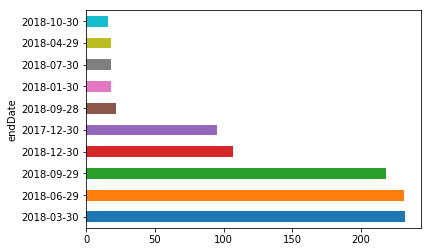

In [33]:
# show distribution of filling dates for the universe
field = 'cash'
fil_period = latest_finBS[(latest_finBS.period == 'Q')]
date_count_df = fil_period.groupby(
    fil_period.index).count().sort_values(
        by=field, ascending=False).head(10)
date_count_df[field].plot.barh();

### Select company

In [11]:
symbol = 'AAPL'
key_stats_df = latest_keystats[latest_keystats.symbol == symbol]
fin_stats_df = latest_finstats[latest_finstats.symbol == symbol]
quote_df = latest_quotes[latest_quotes.symbol == symbol]

### Perform analysis

In [39]:
def get_BS_metrics(latest_finBS, symbol, filterCol):
    df = latest_finBS[latest_finBS.symbol == symbol]
    df = df.dropna(subset=['cash']).sort_index()
    df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], True, excl_cols)
    # print_labels("BS", df)

    wc_assets = ['netReceivables', 'inventory']
    wc_liabs = ['accountsPayable']
    total_cash = ['cash', 'shortTermInvestments', 'longTermInvestments']
    total_debt = ['shortLongTermDebt', 'longTermDebt']
    bs_summary = ['totalAssets', 'workingCapital', 'adjAssetBase',
                  'totalCash', 'adjAssetBaseLessCash', 'netDebt']

    df.loc[:, 'workingCapital'] = fs_total_subset(df, wc_assets) - fs_total_subset(df, wc_liabs)
    df.loc[:, 'adjAssetBase'] = df['totalAssets'] + df['workingCapital'].apply(min, args=(0,))
    df.loc[:, 'totalCash'] = fs_total_subset(df, total_cash)
    df.loc[:, 'totalDebt'] = fs_total_subset(df, total_debt)
    df.loc[:, 'netDebt'] = df['totalDebt'] - df['totalCash']
    df.loc[:, 'adjAssetBaseLessCash'] = df['adjAssetBase'] + df['netDebt'].apply(min, args=(0,))
    # bs_sum = (df[bs_summary] / UNIT_SCALE).T.round(1)
    return (df[bs_summary] / UNIT_SCALE).T.round(1)

In [40]:
bs_sum = get_BS_metrics(latest_finBS, symbol, 'cash')
bs_sum

endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
totalAssets,321.7,375.3,365.7,373.7
workingCapital,-5.9,-3.7,-2.9,-2.3
adjAssetBase,315.8,371.6,362.8,371.4
totalCash,237.6,268.9,237.1,245.0
adjAssetBaseLessCash,157.2,206.4,228.2,229.1
netDebt,-158.7,-165.2,-134.6,-142.3


In [38]:
# Balance Sheet
df = latest_finBS[latest_finBS.symbol == symbol]
df = df.dropna(subset=['cash']).sort_index()
# df[df.period == 'A'].iloc[-3:].append(df[df.period == 'Q'].iloc[-1:,:])
df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], True, excl_cols)
print_labels("BS", df)

wc_assets = ['netReceivables', 'inventory']
wc_liabs = ['accountsPayable']
total_cash = ['cash', 'shortTermInvestments', 'longTermInvestments']
total_debt = ['shortLongTermDebt', 'longTermDebt']
bs_summary = ['totalAssets', 'workingCapital', 'adjAssetBase',
              'totalCash', 'adjAssetBaseLessCash', 'netDebt']

df.loc[:, 'workingCapital'] = fs_total_subset(df, wc_assets) - fs_total_subset(df, wc_liabs)
df.loc[:, 'adjAssetBase'] = df['totalAssets'] + df['workingCapital'].apply(min, args=(0,))
df.loc[:, 'totalCash'] = fs_total_subset(df, total_cash)
df.loc[:, 'totalDebt'] = fs_total_subset(df, total_debt)
df.loc[:, 'netDebt'] = df['totalDebt'] - df['totalCash']
df.loc[:, 'adjAssetBaseLessCash'] = df['adjAssetBase'] + df['netDebt'].apply(min, args=(0,))
bs_sum = df[bs_summary].copy()
(bs_sum / UNIT_SCALE).T.round(1)

BS labels:
['maxAge', 'cash', 'shortTermInvestments', 'netReceivables', 'inventory', 'otherCurrentAssets', 'totalCurrentAssets', 'longTermInvestments', 'propertyPlantEquipment', 'goodWill', 'intangibleAssets', 'otherAssets', 'deferredLongTermAssetCharges', 'totalAssets', 'accountsPayable', 'shortLongTermDebt', 'otherCurrentLiab', 'longTermDebt', 'otherLiab', 'minorityInterest', 'totalCurrentLiabilities', 'totalLiab', 'retainedEarnings', 'treasuryStock', 'capitalSurplus', 'otherStockholderEquity', 'totalStockholderEquity', 'netTangibleAssets', 'symbol', 'period', 'commonStock', 'deferredLongTermLiab', 'storeDate']


endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
totalAssets,321.7,375.3,365.7,373.7
workingCapital,-5.9,-3.7,-2.9,-2.3
adjAssetBase,315.8,371.6,362.8,371.4
totalCash,237.6,268.9,237.1,245.0
adjAssetBaseLessCash,157.2,206.4,228.2,229.1
netDebt,-158.7,-165.2,-134.6,-142.3


In [17]:
# Cash flow items
df = latest_finCF[latest_finCF.symbol == symbol]
df = df.dropna(subset=['totalCashFromOperatingActivities']).sort_index()
df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], False, excl_cols)
print_labels("CF", df)

cf_summary = ['totalCashFromOperatingActivities', 'depreciation', 
              'steadyCF', 'capitalExpenditures', 
              'netBorrowings', 'steadyFCF', 'growthCapex', 
              'repurchaseOfStock', 'dividendsPaid', 'sbcAddbacks']

df.loc[:, 'steadyCF'] = df.totalCashFromOperatingActivities - df['depreciation']
df.loc[:, 'steadyFCF'] = df['steadyCF'] + df['netBorrowings'].apply(min, args=(0,))
df.loc[:, 'growthCapex'] = np.abs(df.capitalExpenditures) - df.depreciation
df.loc[:, 'sbcAddbacks'] = fs_total_subset(
    df, ['changeToNetincome', 'changeToOperatingActivities'])
cf_sum = df[valid_cols(df, cf_summary)].copy()
(cf_sum / UNIT_SCALE).T.round(1)

CF labels:
['maxAge', 'netIncome', 'depreciation', 'changeToNetincome', 'changeToAccountReceivables', 'changeToLiabilities', 'changeToInventory', 'changeToOperatingActivities', 'totalCashFromOperatingActivities', 'capitalExpenditures', 'investments', 'otherCashflowsFromInvestingActivities', 'totalCashflowsFromInvestingActivities', 'dividendsPaid', 'netBorrowings', 'otherCashflowsFromFinancingActivities', 'totalCashFromFinancingActivities', 'effectOfExchangeRate', 'changeInCash', 'repurchaseOfStock', 'issuanceOfStock', 'symbol', 'period', 'storeDate']


endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
depreciation,10.5,10.2,10.9,11.6
totalCashFromOperatingActivities,66.2,64.2,77.4,75.8
capitalExpenditures,-12.7,-12.5,-13.3,-13.9
dividendsPaid,-12.2,-12.8,-13.7,-13.9
netBorrowings,22.1,29.0,0.4,-6.5
repurchaseOfStock,-31.3,-34.8,-75.3,-74.2
steadyCF,55.7,54.1,66.5,64.3
steadyFCF,55.7,54.1,66.5,57.7
growthCapex,2.2,2.3,2.4,2.3
sbcAddbacks,8.7,2.2,2.4,15.3


In [18]:
# Income statement calcs
df = latest_finIS[latest_finIS.symbol == symbol]
df = df.dropna(subset=['totalOperatingExpenses']).sort_index()
df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], False, excl_cols)
print_labels("IS", df)

cash_cost_growth = ['researchDevelopment',
                    'sellingGeneralAdministrative']
is_summary = ['totalRevenue','growthCost']

cost_gr_df = fs_total_subset(df, cash_cost_growth)
df.loc[:, 'growthCost'] = (cost_gr_df - cost_gr_df.shift(1)) \
    - cf_sum.sbcAddbacks.apply(min, args=(0,))

is_sum = df[valid_cols(df, is_summary)].copy()
(is_sum / UNIT_SCALE).T.round(1)

IS labels:
['maxAge', 'totalRevenue', 'costOfRevenue', 'grossProfit', 'sellingGeneralAdministrative', 'otherOperatingExpenses', 'totalOperatingExpenses', 'operatingIncome', 'totalOtherIncomeExpenseNet', 'ebit', 'interestExpense', 'incomeBeforeTax', 'incomeTaxExpense', 'minorityInterest', 'netIncomeFromContinuingOps', 'netIncome', 'netIncomeApplicableToCommonShares', 'symbol', 'period', 'researchDevelopment', 'discontinuedOperations', 'storeDate']


endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
totalRevenue,215.6,229.2,265.6,261.6
growthCost,NaN,2.6,4.1,1.0


In [19]:
# Income statement calcs
df = latest_finIS.copy()
mask_symbol = (df.symbol == symbol) 
df = df[mask_symbol]
print_labels("IS", df)

cash_cost_growth = ['researchDevelopment',
                    'sellingGeneralAdministrative']
is_summary = ['totalRevenue','growthCost']

dfA = df[(df.period == 'A')]
dfQ = df[(df.period == 'Q')]
dfA = fs_append_ltm(dfA, dfQ, False, excl_cols)
cost_gr_df = fs_total_subset(dfA, cash_cost_growth)
dfA.loc[:, 'growthCost'] = (cost_gr_df - cost_gr_df.shift(1)) \
    - cf_sum.sbcAddbacks.apply(min, args=(0,))

is_sum = dfA[valid_cols(dfA, is_summary)].copy()
(is_sum / UNIT_SCALE).T.round(1)

IS labels:
['maxAge', 'totalRevenue', 'costOfRevenue', 'grossProfit', 'sellingGeneralAdministrative', 'otherOperatingExpenses', 'totalOperatingExpenses', 'operatingIncome', 'totalOtherIncomeExpenseNet', 'ebit', 'interestExpense', 'incomeBeforeTax', 'incomeTaxExpense', 'minorityInterest', 'netIncomeFromContinuingOps', 'netIncome', 'netIncomeApplicableToCommonShares', 'symbol', 'period', 'researchDevelopment', 'discontinuedOperations', 'storeDate']


endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
totalRevenue,215.6,229.2,265.6,261.6
growthCost,NaN,2.6,4.1,1.0


In [20]:
# Valuation calculations
key_cols = ['totalAssets','adjAssetBaseLessCash', 'netDebt',
           'totalRevenue', 'steadyCF', 'steadyFCF', 'reinvCapital',
           'ROA', 'ROE', 'AT', 'AAT']

val_df = bs_sum.copy()
val_df[cf_sum.columns] = cf_sum
val_df[is_sum.columns] = is_sum
val_df['avgTotalAssets'] = val_df['totalAssets'].rolling(2).mean() # avg asset base
val_df['avgAssetBaseLC'] = val_df['adjAssetBaseLessCash'].rolling(2).mean() # avg asset base
val_df.avgTotalAssets[0] = val_df.totalAssets[0]
val_df.avgAssetBaseLC[0] = val_df.adjAssetBaseLessCash[0]
val_df['reinvCapital'] = (val_df['growthCapex'] + val_df['growthCost']).apply(max, args=(0,))
val_df['ROA'] = (val_df.steadyCF / val_df.avgTotalAssets)
val_df['ROE'] = (val_df.steadyFCF / val_df.avgAssetBaseLC)
val_df['AT'] = (val_df.totalRevenue / val_df.avgTotalAssets)
val_df['AAT'] = (val_df.totalRevenue / val_df.avgAssetBaseLC)
# ROA.mean().round(2), ROE.mean().round(2), AT.mean().round(2), AAT.mean().round(2)
(val_df[key_cols[:-4]] / UNIT_SCALE).T.round(1)

endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
totalAssets,321.7,375.3,365.7,373.7
adjAssetBaseLessCash,157.2,206.4,228.2,229.1
netDebt,-158.7,-165.2,-134.6,-142.3
totalRevenue,215.6,229.2,265.6,261.6
steadyCF,55.7,54.1,66.5,64.3
steadyFCF,55.7,54.1,66.5,57.7
reinvCapital,NaN,4.9,6.5,3.4


In [21]:
years = (val_df.index[-1] -   val_df.index[0]).days / 365
cagr_series = pow(val_df.iloc[-1] / val_df.iloc[0], (1 / years)) - 1
cagr_series['steadyFCF']

0.015851106800996773

In [22]:
# historical growth rates
# growth_cols = ['totalRevenue','totalAssets', 'totalCashFromOperatingActivities', 'steadyCF', 'steadyFCF', 'capitalExpenditures', 'reinvCapital']
growth_cols = ['steadyFCF']
cagr_series[growth_cols].median()
growth_rate = max(cagr_series[growth_cols].median(), 0)
cagr_series[growth_cols], growth_rate

(steadyFCF    0.015851
 dtype: float64, 0.015851106800996773)

In [23]:
(val_df[val_df.columns[-4:]]).T.round(2)

endDate,2016-09-23,2017-09-29,2018-09-28,2018-12-28
ROA,0.17,0.16,0.18,0.17
ROE,0.35,0.30,0.31,0.25
AT,0.67,0.66,0.72,0.71
AAT,1.37,1.26,1.22,1.14


In [24]:
ROIC_stats = val_df[['ROA', 'ROE','AT', 'AAT']].mean()
ROE = ROIC_stats.ROE
ROIC_stats

ROA    0.170447
ROE    0.302670
AT     0.688128
AAT    1.249832
dtype: float64

In [25]:
discount = 0.028 + 0.05 + 0.005
gr_discount = discount * 1
# models fails to incorporate future growth
# consider discount rate - actual growth * capitalization factor of [0.3] 
growth = growth_rate * 0.3
mult = round(1/discount, 2)
gr_mult = mult + growth * 100
mult, gr_mult

(12.05, 12.525533204029903)

In [26]:
npv_CF = val_df.steadyCF[-1] * mult
npv_GR = (val_df.reinvCapital.sum() * ROE * gr_mult) \
    if val_df.reinvCapital.sum() > 0 else 0
[round(x/UNIT_SCALE,2) for x in [npv_CF, -val_df.netDebt[-1], npv_GR]]

[774.55, 142.27, 55.95]

In [27]:
fxes_df = latest_quotes[latest_quotes.quoteType == 'CURRENCY']
tgt_FX = fin_stats_df.iloc[0].financialCurrency
FX = 1 if tgt_FX == 'USD' else get_FX(fxes_df, tgt_FX)

In [28]:
# challenge here with dual class companies
sharesOut = key_stats_df.sharesOutstanding
equityVal = (npv_CF - val_df.netDebt[-1] + npv_GR) * FX

In [29]:
prem_disc = (quote_df.iloc[0].marketCap / equityVal)
print_fmt = 'Current Market Cap: {}, Valuation: {}, Prem/Disc. {}'
print(print_fmt.format(
    round(quote_df.iloc[0].marketCap / UNIT_SCALE, 1), 
    round(equityVal / UNIT_SCALE, 1),
    round(prem_disc, 2)))

Current Market Cap: 805.4, Valuation: 972.8, Prem/Disc. 0.83
